## This notebook prepares for decoding (both 1D and 2D)
### Use this notebook to run session/day of each dataset from new animal

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import os
import cupy as cp

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [4]:
from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_position import IntervalLinearizedPosition

import spyglass.spikesorting.v0 as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

from replay_trajectory_classification.environments import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters
from replay_trajectory_classification import ClusterlessClassifier



import pprint
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import EpochPos,TrialChoice,Decode,DecodeResultsLinear
from spyglass.shijiegu.decodeHelpers import (thresholder_sort,
            runSessionNames,sleepSessionNames,populateUnitMarks,
            intersectValidIntervals)

[2025-04-21 14:37:00,415][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
21-Apr-25 14:37:00 Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-04-21 14:37:00,493][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306
21-Apr-25 14:37:00 Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [5]:
from spyglass.shijiegu.decodeHelpers import decodePrepMasterSession

## Table stream:
#### The thresholder sorter will fill `SpikeSorting`, then we fill `Curation`, `UnitMarks`
### 1. The final product is `UnitMarksIndicator`, which include spike and location

In [6]:
nwb_copy_file_name = 'Julio20230811_.nwb'

In [7]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '07_Seq2Session4', '09_Seq2Session5']


In [8]:
sleep_interval, sleep_position_interval = sleepSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '07_Seq2Session4', '09_Seq2Session5']


In [14]:
e = 2
sorting_keys = thresholder_sort(nwb_copy_file_name,session_interval[e],True)

2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
8
inserting into IntervalList
done inserting into IntervalList
11
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
22
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
done inserting into IntervalList
36
inserting into IntervalList
done inserting

[19:01:57][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 11, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:01:57 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 11, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:03:20][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:03:20 Saving sorting results...
[19:03:30][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 12, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:03:30 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 12, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_12_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:04:52][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:04:52 Saving sorting results...
[19:05:02][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 15, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:05:02 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 15, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_15_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:06:25][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:06:25 Saving sorting results...
[19:06:35][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 20, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:06:35 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 20, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:07:56][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:07:56 Saving sorting results...
[19:08:06][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 22, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:08:06 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 22, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_22_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:09:30][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:09:30 Saving sorting results...
[19:09:41][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 26, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:09:41 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 26, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_26_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:11:03][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:11:03 Saving sorting results...
[19:11:13][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 28, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_28_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:11:13 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 28, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_28_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:12:35][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:12:35 Saving sorting results...
[19:12:45][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 29, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_29_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:12:45 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 29, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_29_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:14:08][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:14:08 Saving sorting results...
[19:14:18][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 2, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:14:18 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 2, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:15:40][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:15:40 Saving sorting results...
[19:15:50][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 30, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_30_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:15:50 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 30, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_30_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:17:12][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:17:12 Saving sorting results...
[19:17:22][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 31, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_31_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:17:22 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 31, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_31_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:18:44][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:18:44 Saving sorting results...
[19:18:55][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 36, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_36_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:18:55 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 36, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_36_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:20:17][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:20:17 Saving sorting results...
[19:20:27][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 3, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:20:27 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 3, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_3_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:21:50][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:21:50 Saving sorting results...
[19:22:01][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 42, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_42_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:22:01 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 42, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_42_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:23:22][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:23:22 Saving sorting results...
[19:23:33][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 43, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_43_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:23:33 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 43, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_43_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:24:56][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:24:56 Saving sorting results...
[19:25:05][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 49, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_49_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:25:05 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 49, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_49_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:26:26][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:26:26 Saving sorting results...
[19:26:37][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 50, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:26:37 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 50, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_50_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:27:59][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:27:59 Saving sorting results...
[19:28:09][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 51, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_51_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:28:09 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 51, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_51_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:29:31][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:29:31 Saving sorting results...
[19:29:41][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 52, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_52_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:29:41 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 52, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_52_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:31:03][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:31:03 Saving sorting results...
[19:31:13][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 55, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_55_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:31:13 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 55, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_55_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:32:35][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:32:35 Saving sorting results...
[19:32:45][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 56, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_56_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:32:45 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 56, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_56_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:34:06][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:34:06 Saving sorting results...
[19:34:16][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 61, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:34:16 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 61, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_61_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:35:39][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:35:39 Saving sorting results...
[19:35:49][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 6, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:35:49 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 6, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_6_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:37:10][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:37:10 Saving sorting results...
[19:37:21][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 7, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:37:21 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 7, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_7_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:38:43][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:38:43 Saving sorting results...
[19:38:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 8, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
20-Apr-25 19:38:53 Running spike sorting on {'nwb_file_name': 'Julio20230811_.nwb', 'sort_group_id': 8, 'sort_interval_name': '06_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'Julio20230811_.nwb_06_Seq2Session3_8_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/998 [00:00<?, ?it/s]

[19:40:15][INFO] Spyglass: Saving sorting results...
20-Apr-25 19:40:15 Saving sorting results...


In [42]:
#%debug

In [139]:
(ArtifactDetectionSelection & {"nwb_file_name":nwb_copy_file_name,
                              "sort_interval_name":"04_Seq2Session2"}).fetch()

array([('julio20230811_.nwb', 100, '04_Seq2Session2', 'franklab_tetrode_hippocampus', 'SequenceTask', 'ampl_100_prop_05_2ms', 0),
       ('julio20230811_.nwb', 101, '04_Seq2Session2', 'franklab_tetrode_hippocampus', 'SequenceTask', 'ampl_100_prop_05_2ms', 0)],
      dtype=[('nwb_file_name', 'O'), ('sort_group_id', '<i8'), ('sort_interval_name', 'O'), ('preproc_params_name', 'O'), ('team_name', 'O'), ('artifact_params_name', 'O'), ('custom_artifact_detection', '<i8')])

In [17]:
mark_parameters_keys = populateUnitMarks(sorting_keys)

[19:43:37][INFO] Spyglass: Found 1 accepted units
20-Apr-25 19:43:37 Found 1 accepted units
[19:43:40][INFO] Spyglass: Writing new NWB file Julio20230811_JGOX33B0QD.nwb
20-Apr-25 19:43:40 Writing new NWB file Julio20230811_JGOX33B0QD.nwb
[19:43:42][INFO] Spyglass: Found 1 accepted units
20-Apr-25 19:43:42 Found 1 accepted units
[19:43:43][INFO] Spyglass: Writing new NWB file Julio20230811_KNJ3K0S4OZ.nwb
20-Apr-25 19:43:43 Writing new NWB file Julio20230811_KNJ3K0S4OZ.nwb
[19:43:44][INFO] Spyglass: Found 1 accepted units
20-Apr-25 19:43:44 Found 1 accepted units
[19:43:45][INFO] Spyglass: Writing new NWB file Julio20230811_K0EQEE75MM.nwb
20-Apr-25 19:43:45 Writing new NWB file Julio20230811_K0EQEE75MM.nwb
[19:43:47][INFO] Spyglass: Found 1 accepted units
20-Apr-25 19:43:47 Found 1 accepted units
[19:43:48][INFO] Spyglass: Writing new NWB file Julio20230811_2RWH63BQCZ.nwb
20-Apr-25 19:43:48 Writing new NWB file Julio20230811_2RWH63BQCZ.nwb
[19:43:49][INFO] Spyglass: Found 1 accepted unit

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:44][INFO] Spyglass: Writing new NWB file Julio20230811_NAXP791IN4.nwb
20-Apr-25 19:44:44 Writing new NWB file Julio20230811_NAXP791IN4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:47][INFO] Spyglass: Writing new NWB file Julio20230811_2RPYIZQFIH.nwb
20-Apr-25 19:44:47 Writing new NWB file Julio20230811_2RPYIZQFIH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:49][INFO] Spyglass: Writing new NWB file Julio20230811_HLL1PQII0A.nwb
20-Apr-25 19:44:49 Writing new NWB file Julio20230811_HLL1PQII0A.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:52][INFO] Spyglass: Writing new NWB file Julio20230811_ROD0TU372R.nwb
20-Apr-25 19:44:52 Writing new NWB file Julio20230811_ROD0TU372R.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:54][INFO] Spyglass: Writing new NWB file Julio20230811_YWOBB3H9H8.nwb
20-Apr-25 19:44:54 Writing new NWB file Julio20230811_YWOBB3H9H8.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:44:57][INFO] Spyglass: Writing new NWB file Julio20230811_W83ZMOSG4T.nwb
20-Apr-25 19:44:57 Writing new NWB file Julio20230811_W83ZMOSG4T.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:00][INFO] Spyglass: Writing new NWB file Julio20230811_UMUM237U7U.nwb
20-Apr-25 19:45:00 Writing new NWB file Julio20230811_UMUM237U7U.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:03][INFO] Spyglass: Writing new NWB file Julio20230811_5APZP0XA8X.nwb
20-Apr-25 19:45:03 Writing new NWB file Julio20230811_5APZP0XA8X.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:06][INFO] Spyglass: Writing new NWB file Julio20230811_6RNA99MWGE.nwb
20-Apr-25 19:45:06 Writing new NWB file Julio20230811_6RNA99MWGE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:09][INFO] Spyglass: Writing new NWB file Julio20230811_B6MWR2ZFH0.nwb
20-Apr-25 19:45:09 Writing new NWB file Julio20230811_B6MWR2ZFH0.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:11][INFO] Spyglass: Writing new NWB file Julio20230811_HX754JEFN8.nwb
20-Apr-25 19:45:11 Writing new NWB file Julio20230811_HX754JEFN8.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:14][INFO] Spyglass: Writing new NWB file Julio20230811_5BMC8QXW42.nwb
20-Apr-25 19:45:14 Writing new NWB file Julio20230811_5BMC8QXW42.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:17][INFO] Spyglass: Writing new NWB file Julio20230811_ED2QB08M2S.nwb
20-Apr-25 19:45:17 Writing new NWB file Julio20230811_ED2QB08M2S.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:20][INFO] Spyglass: Writing new NWB file Julio20230811_M5XRJ4VTG3.nwb
20-Apr-25 19:45:20 Writing new NWB file Julio20230811_M5XRJ4VTG3.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:22][INFO] Spyglass: Writing new NWB file Julio20230811_RM30MLTS30.nwb
20-Apr-25 19:45:22 Writing new NWB file Julio20230811_RM30MLTS30.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:26][INFO] Spyglass: Writing new NWB file Julio20230811_XN20B0G86F.nwb
20-Apr-25 19:45:26 Writing new NWB file Julio20230811_XN20B0G86F.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:28][INFO] Spyglass: Writing new NWB file Julio20230811_2BVU7NBJC4.nwb
20-Apr-25 19:45:28 Writing new NWB file Julio20230811_2BVU7NBJC4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:31][INFO] Spyglass: Writing new NWB file Julio20230811_M4JE3LQF6P.nwb
20-Apr-25 19:45:31 Writing new NWB file Julio20230811_M4JE3LQF6P.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:34][INFO] Spyglass: Writing new NWB file Julio20230811_FTIGK58148.nwb
20-Apr-25 19:45:34 Writing new NWB file Julio20230811_FTIGK58148.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:37][INFO] Spyglass: Writing new NWB file Julio20230811_U4HCQJS8BQ.nwb
20-Apr-25 19:45:37 Writing new NWB file Julio20230811_U4HCQJS8BQ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:40][INFO] Spyglass: Writing new NWB file Julio20230811_8KH9A3Z6N7.nwb
20-Apr-25 19:45:40 Writing new NWB file Julio20230811_8KH9A3Z6N7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:42][INFO] Spyglass: Writing new NWB file Julio20230811_XNNX1Z266N.nwb
20-Apr-25 19:45:42 Writing new NWB file Julio20230811_XNNX1Z266N.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:45][INFO] Spyglass: Writing new NWB file Julio20230811_30EKCH88IC.nwb
20-Apr-25 19:45:45 Writing new NWB file Julio20230811_30EKCH88IC.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:48][INFO] Spyglass: Writing new NWB file Julio20230811_7UZRASL88A.nwb
20-Apr-25 19:45:48 Writing new NWB file Julio20230811_7UZRASL88A.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[19:45:51][INFO] Spyglass: Writing new NWB file Julio20230811_PCUCZEL3YT.nwb
20-Apr-25 19:45:51 Writing new NWB file Julio20230811_PCUCZEL3YT.nwb


In [18]:
(SpikeSorting & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
Julio20230811_.nwb,2,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ae361963_spikesorting,1745201740
Julio20230811_.nwb,3,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_3_franklab_tetrode_hippocampus_926fd943_spikesorting,1745202110
Julio20230811_.nwb,6,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_6_franklab_tetrode_hippocampus_0af1a93e_spikesorting,1745203030
Julio20230811_.nwb,7,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_7_franklab_tetrode_hippocampus_5d2faf7a_spikesorting,1745203123
Julio20230811_.nwb,8,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_8_franklab_tetrode_hippocampus_38599db0_spikesorting,1745203215
Julio20230811_.nwb,11,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_11_franklab_tetrode_hippocampus_35403219_spikesorting,1745201000
Julio20230811_.nwb,12,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_12_franklab_tetrode_hippocampus_86077ec4_spikesorting,1745201092
Julio20230811_.nwb,15,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_15_franklab_tetrode_hippocampus_2f6204fc_spikesorting,1745201185
Julio20230811_.nwb,20,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_24215809_spikesorting,1745201276
Julio20230811_.nwb,22,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/Julio20230811_.nwb_06_Seq2Session3_22_franklab_tetrode_hippocampus_2e605eca_spikesorting,1745201370


In [9]:
import spikeinterface as si

In [10]:
nwb_copy_file_name = 'julio20230811_.nwb'
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '07_Seq2Session4', '09_Seq2Session5']


In [11]:
sort_interval_name = '06_Seq2Session3'
#array([('julio20230811_.nwb', 100, '04_Seq2Session2', 'franklab_tetrode_hippocampus', 'SequenceTask', 'ampl_100_prop_05_2ms', 0),
#       ('julio20230811_.nwb', 101, '04_Seq2Session2', 'franklab_tetrode_hippocampus', 'SequenceTask', 'ampl_100_prop_05_2ms', 0)],
      
from spyglass.shijiegu.helpers import interval_union

In [12]:
statescript_key = {'nwb_file_name':nwb_copy_file_name,
                   'epoch_name':sort_interval_name}

StateScript = pd.DataFrame(
    (TrialChoice & statescript_key).fetch1('choice_reward'))
trial_1_t = StateScript.loc[1].timestamp_O
trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O

In [13]:
key = {'nwb_file_name' : nwb_copy_file_name,
       'sort_interval_name':sort_interval_name,
       "preproc_params_name":"franklab_tetrode_hippocampus",
       "sort_group_id":100}
recording_path = (SpikeSortingRecording & key).fetch1(
                "recording_path"
            )
recording_name = SpikeSortingRecording._get_recording_name(key)
recording = si.load_extractor(recording_path)

In [14]:
if recording.get_num_segments() > 1:
    valid_timestamps = np.array([])
    for segment in range(recording.get_num_segments()):
        valid_timestamps = np.concatenate(
                (valid_timestamps, recording.get_times(segment_index=segment))
        )
    recording = si.concatenate_recordings([recording])
elif recording.get_num_segments() == 1:
    valid_timestamps = recording.get_times(0)

In [31]:
valid_timestamps.shape

(29895878,)

In [33]:
from spyglass.spikesorting.v0.spikesorting_artifact import _get_artifact_times

In [40]:
artifact_removed_test, artifact_intervals = _get_artifact_times(recording,amplitude_thresh = 100, proportion_above_thresh = 0.5)

[15:22:28][INFO] Spyglass: using 1 jobs...
21-Apr-25 15:22:28 using 1 jobs...


AssertionError: 

In [42]:
#%debug

(1691786057.8352175, 1691787177.2597272)

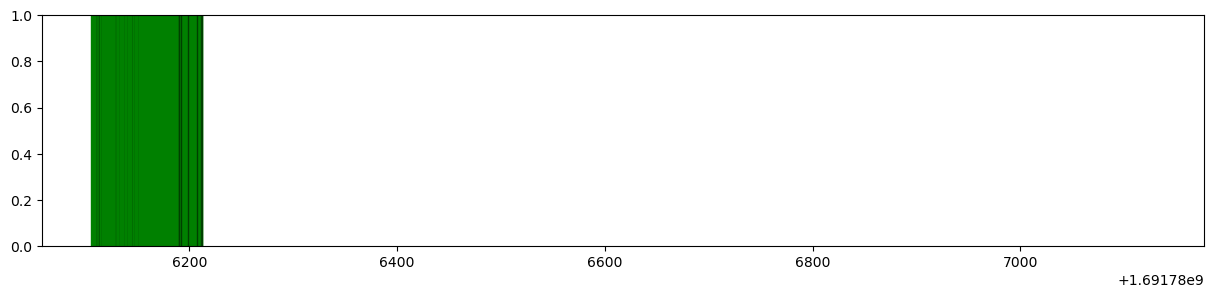

In [30]:
fig, ax = plt.subplots(1,1,figsize = (15,3))

for a_ind in range(artifact_removed_test.shape[0]):
    ax.axvspan(artifact_removed_test[a_ind][0],artifact_removed_test[a_ind][1],color = 'g',linewidth = 1)
    ax.axvspan(artifact_intervals[a_ind][0],artifact_intervals[a_ind][1],color = 'k',linewidth = 1,alpha = 0.5)

ax.set_xlim(trial_1_t-100,trial_last_t+100)

In [15]:
valid_timestamps[0]

1691786105.633824

In [16]:
recording

BinaryFolderRecording: 60 channels - 30.0kHz - 1 segments - 29,895,878 samples 
                       997.88s (16.63 minutes) - int16 dtype - 3.34 GiB

In [174]:
(SpikeSortingRecording & )

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list
julio20230811_.nwb,100,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,/stelmo/nwb/recording/julio20230811_.nwb_06_Seq2Session3_100_franklab_tetrode_hippocampus,julio20230811_.nwb_06_Seq2Session3_100_franklab_tetrode_hippocampus


In [44]:
"""fetch artifact"""
artifact_params_name='ampl_100_prop_05_2ms'
artifact_key=(ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name}
                            & {'artifact_params_name': artifact_params_name}
                            & {'sort_interval_name':sort_interval_name})

#, and there should be 2 entries, one from left cannula (group 100), and one from right cannula (group 101)
artifact_removed_name_list=artifact_key.fetch('artifact_removed_interval_list_name')

artifact_time_list=[]
artifact_removed_time_list=[]
for artifact_removed_name in artifact_removed_name_list:
    artifact_time_list.append((ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name,'artifact_removed_interval_list_name':artifact_removed_name}).fetch1('artifact_times'))
    (IntervalList() & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':artifact_removed_name}).delete()


In [79]:
intvls = (IntervalList() & {'nwb_file_name' : nwb_copy_file_name}).fetch("interval_list_name")

In [80]:
intvls

array(['01_Seq2Sleep1', '02_Seq2Session1', '03_Seq2Sleep2',
       '04_Seq2Session2', '05_Seq2Sleep3', '06_Seq2Session3',
       '07_Seq2Session4', '08_Seq2Sleep4', '09_Seq2Session5',
       '10_Seq2Sleep5',
       'julio20230811_.nwb_01_Seq2Sleep1_11_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_12_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_15_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_20_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_22_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_26_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_28_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_29_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_2_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_30_franklab_tetrode_hippocampus',
       'julio20230811_.nwb_01_Seq2Sleep1_31

In [83]:
for intvl in intvls:
    if "valid_times" in intvl:
        (IntervalList() & {'nwb_file_name' : nwb_copy_file_name,
                   "interval_list_name":intvl}).delete()

[15:47:06][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:06 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:09][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:09 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:47:10,859][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:47:10 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:47:12,531][INFO]: Deletes committed.
21-Apr-25 15:47:12 Deletes committed.
[15:47:12][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:12 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:15][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:15 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:47:16,574][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:47:16 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:47:20,555][INFO]: Deletes committed.
21-Apr-25 15:47:20 Deletes committed.
[15:47:20][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:20 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:23][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:23 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:47:24,407][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:47:24 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:47:25,798][INFO]: Deletes committed.
21-Apr-25 15:47:25 Deletes committed.
[15:47:25][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:25 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:28][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:28 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:47:29,521][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:47:29 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:47:30,805][INFO]: Deletes committed.
21-Apr-25 15:47:30 Deletes committed.
[15:47:30][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:30 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:33][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:33 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:47:34,646][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:47:34 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:47:35,959][INFO]: Deletes committed.
21-Apr-25 15:47:35 Deletes committed.
[15:47:36][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:36 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:39][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:39 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:47:40,094][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:47:40 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:47:41,269][INFO]: Deletes committed.
21-Apr-25 15:47:41 Deletes committed.
[15:47:41][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:41 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:43][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:43 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:47:44,888][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:47:44 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:47:46,182][INFO]: Deletes committed.
21-Apr-25 15:47:46 Deletes committed.
[15:47:46][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:46 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:49][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:49 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:47:50,154][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:47:50 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:47:51,578][INFO]: Deletes committed.
21-Apr-25 15:47:51 Deletes committed.
[15:47:51][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:51 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:54][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:54 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:47:54,955][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:47:54 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:47:56,365][INFO]: Deletes committed.
21-Apr-25 15:47:56 Deletes committed.
[15:47:56][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:47:56 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:47:59][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:47:59 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:00,177][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:00 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:01,545][INFO]: Deletes committed.
21-Apr-25 15:48:01 Deletes committed.
[15:48:01][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:01 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:04][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:04 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:05,561][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:05 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:06,754][INFO]: Deletes committed.
21-Apr-25 15:48:06 Deletes committed.
[15:48:06][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:06 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:09][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:09 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:10,842][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:10 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:12,400][INFO]: Deletes committed.
21-Apr-25 15:48:12 Deletes committed.
[15:48:12][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:12 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:15][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:15 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:16,030][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:16 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:17,328][INFO]: Deletes committed.
21-Apr-25 15:48:17 Deletes committed.
[15:48:17][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:17 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:20][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:20 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:21,379][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:21 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:22,637][INFO]: Deletes committed.
21-Apr-25 15:48:22 Deletes committed.
[15:48:22][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:22 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:25][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:25 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:26,507][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:26 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:29,326][INFO]: Deletes committed.
21-Apr-25 15:48:29 Deletes committed.
[15:48:29][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:29 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:32][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:32 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:33,274][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:33 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:35,228][INFO]: Deletes committed.
21-Apr-25 15:48:35 Deletes committed.
[15:48:35][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:35 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:38][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:38 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:39,305][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:39 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:40,744][INFO]: Deletes committed.
21-Apr-25 15:48:40 Deletes committed.
[15:48:40][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:40 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:43][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:43 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:44,486][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:44 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:45,990][INFO]: Deletes committed.
21-Apr-25 15:48:45 Deletes committed.
[15:48:46][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:46 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:48][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:48 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:49,795][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:49 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:48:51,062][INFO]: Deletes committed.
21-Apr-25 15:48:51 Deletes committed.
[15:48:51][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:48:51 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:48:54][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:48:54 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:48:55,117][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:48:55 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:00,193][INFO]: Deletes committed.
21-Apr-25 15:49:00 Deletes committed.
[15:49:00][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:00 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:03][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:03 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:04,372][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:04 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:05,859][INFO]: Deletes committed.
21-Apr-25 15:49:05 Deletes committed.
[15:49:05][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:05 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:09][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:09 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:10,077][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:10 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:11,877][INFO]: Deletes committed.
21-Apr-25 15:49:11 Deletes committed.
[15:49:11][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:11 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:14][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:14 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:15,910][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:15 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:18,424][INFO]: Deletes committed.
21-Apr-25 15:49:18 Deletes committed.
[15:49:18][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:18 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:21][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:21 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:22,460][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:22 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:24,040][INFO]: Deletes committed.
21-Apr-25 15:49:24 Deletes committed.
[15:49:24][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:24 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:26][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:26 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:27,971][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:27 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:29,540][INFO]: Deletes committed.
21-Apr-25 15:49:29 Deletes committed.
[15:49:29][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:29 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:31][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:31 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:32,408][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:32 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:33,915][INFO]: Deletes committed.
21-Apr-25 15:49:33 Deletes committed.
[15:49:33][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:33 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:36][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:36 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:37,765][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:37 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:39,092][INFO]: Deletes committed.
21-Apr-25 15:49:39 Deletes committed.
[15:49:39][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:39 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:42][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:42 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:43,106][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:43 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:44,497][INFO]: Deletes committed.
21-Apr-25 15:49:44 Deletes committed.
[15:49:44][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:44 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:47][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:47 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:48,263][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:48 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:49,654][INFO]: Deletes committed.
21-Apr-25 15:49:49 Deletes committed.
[15:49:49][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:49 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:52][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:52 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:53,581][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:53 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:49:55,005][INFO]: Deletes committed.
21-Apr-25 15:49:55 Deletes committed.
[15:49:55][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:49:55 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:49:58][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:49:58 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:49:59,133][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:49:59 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:01,551][INFO]: Deletes committed.
21-Apr-25 15:50:01 Deletes committed.
[15:50:01][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:01 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:04][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:04 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:04,928][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:04 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:06,594][INFO]: Deletes committed.
21-Apr-25 15:50:06 Deletes committed.
[15:50:06][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:06 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:09][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:09 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:10,846][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:10 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:12,000][INFO]: Deletes committed.
21-Apr-25 15:50:12 Deletes committed.
[15:50:12][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:12 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:15][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:15 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:16,043][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:16 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:17,305][INFO]: Deletes committed.
21-Apr-25 15:50:17 Deletes committed.
[15:50:17][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:17 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:20][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:20 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:21,247][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:21 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:22,657][INFO]: Deletes committed.
21-Apr-25 15:50:22 Deletes committed.
[15:50:22][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:22 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:25][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:25 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:26,368][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:26 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:28,462][INFO]: Deletes committed.
21-Apr-25 15:50:28 Deletes committed.
[15:50:28][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:28 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:31][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:31 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:32,273][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:32 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:38,600][INFO]: Deletes committed.
21-Apr-25 15:50:38 Deletes committed.
[15:50:38][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:38 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:41][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:41 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:42,564][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:42 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:43,850][INFO]: Deletes committed.
21-Apr-25 15:50:43 Deletes committed.
[15:50:43][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:43 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:47][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:47 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:47,956][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:47 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:49,371][INFO]: Deletes committed.
21-Apr-25 15:50:49 Deletes committed.
[15:50:49][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:49 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:52][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:52 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:53,432][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:53 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:50:54,752][INFO]: Deletes committed.
21-Apr-25 15:50:54 Deletes committed.
[15:50:54][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:50:54 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:50:57][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:50:57 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:50:58,673][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:50:58 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:00,035][INFO]: Deletes committed.
21-Apr-25 15:51:00 Deletes committed.
[15:51:00][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:00 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:03][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:03 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:04,098][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:04 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:05,425][INFO]: Deletes committed.
21-Apr-25 15:51:05 Deletes committed.
[15:51:05][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:05 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:08][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:08 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:09,413][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:09 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:10,810][INFO]: Deletes committed.
21-Apr-25 15:51:10 Deletes committed.
[15:51:10][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:10 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:13][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:13 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:14,534][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:14 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:15,842][INFO]: Deletes committed.
21-Apr-25 15:51:15 Deletes committed.
[15:51:15][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:15 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:18][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:18 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:19,715][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:19 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:21,976][INFO]: Deletes committed.
21-Apr-25 15:51:21 Deletes committed.
[15:51:22][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:22 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:25][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:25 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:26,121][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:26 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:27,335][INFO]: Deletes committed.
21-Apr-25 15:51:27 Deletes committed.
[15:51:27][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:27 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:29][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:29 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:30,886][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:30 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:36,819][INFO]: Deletes committed.
21-Apr-25 15:51:36 Deletes committed.
[15:51:36][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:36 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:39][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:39 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:40,812][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:40 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:42,324][INFO]: Deletes committed.
21-Apr-25 15:51:42 Deletes committed.
[15:51:42][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:42 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:45][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:45 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:46,167][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:46 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:47,545][INFO]: Deletes committed.
21-Apr-25 15:51:47 Deletes committed.
[15:51:47][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:47 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:50][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:50 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:51,586][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:51 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:53,512][INFO]: Deletes committed.
21-Apr-25 15:51:53 Deletes committed.
[15:51:53][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:53 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:51:56][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:51:56 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:51:57,654][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:51:57 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:51:59,063][INFO]: Deletes committed.
21-Apr-25 15:51:59 Deletes committed.
[15:51:59][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:51:59 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:52:02][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:52:02 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:52:03,092][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:52:03 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:52:04,462][INFO]: Deletes committed.
21-Apr-25 15:52:04 Deletes committed.
[15:52:04][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:52:04 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
Julio20230811_ Shijie Gu     
 (Total: 1)

[15:52:07][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:52:07 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:52:08,459][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:52:08 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:52:09,983][INFO]: Deletes committed.
21-Apr-25 15:52:09 Deletes committed.
[15:52:10][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:52:10 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

[15:52:13][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:52:13 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:52:14,114][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:52:14 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:52:15,548][INFO]: Deletes committed.
21-Apr-25 15:52:15 Deletes committed.
[15:52:15][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:52:15 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

[15:52:18][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:52:18 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:52:19,657][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:52:19 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:52:22,808][INFO]: Deletes committed.
21-Apr-25 15:52:22 Deletes committed.
[15:52:22][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:52:22 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

[15:52:26][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:52:26 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:52:26,920][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:52:26 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:52:36,620][INFO]: Deletes committed.
21-Apr-25 15:52:36 Deletes committed.
[15:52:36][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

21-Apr-25 15:52:36 Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
julio20230811_ Shijie Gu     
 (Total: 1)

[15:52:39][INFO] Spyglass: Building merge cache for interval_list.
	Found 5 downstream merge tables
21-Apr-25 15:52:39 Building merge cache for interval_list.
	Found 5 downstream merge tables
[2025-04-21 15:52:40,258][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
21-Apr-25 15:52:40 Deleting 1 rows from `common_interval`.`interval_list`


Commit deletes? [yes, No]:  yes


[2025-04-21 15:52:41,755][INFO]: Deletes committed.
21-Apr-25 15:52:41 Deletes committed.


In [18]:
artifact_removed_name_list

array(['julio20230811_.nwb_06_Seq2Session3_100_franklab_tetrode_hippocampus_ampl_100_prop_05_2ms_artifact_removed_valid_times',
       'julio20230811_.nwb_06_Seq2Session3_101_franklab_tetrode_hippocampus_ampl_100_prop_05_2ms_artifact_removed_valid_times'],
      dtype=object)

(1691786057.8352175, 1691787177.2597272)

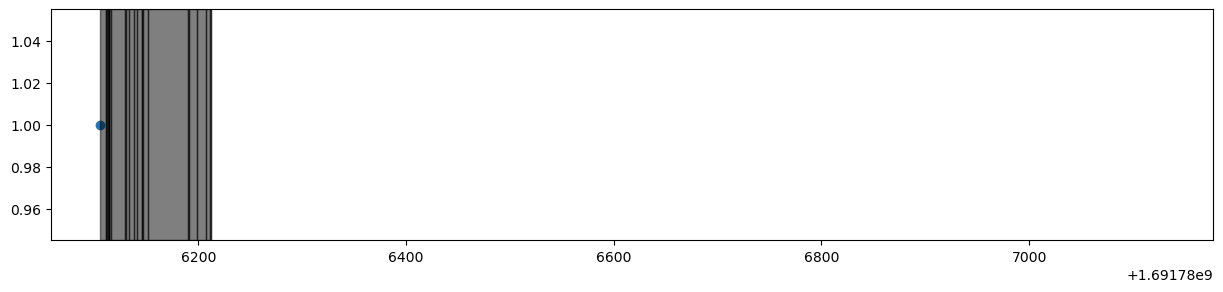

In [21]:
fig, ax = plt.subplots(1,1,figsize = (15,3))

ax.scatter(valid_timestamps[0],1)

for a_ind in range(artifact_removed_time_list[0].shape[0]):
    #ax.axvline(artifact_removed_time_list[0][a_ind][0],color = 'g',linewidth = 1)
    ax.axvspan(artifact_removed_time_list[0][a_ind][0],artifact_removed_time_list[0][a_ind][1],color = 'k',linewidth = 1,alpha = 0.5)

ax.set_xlim(trial_1_t-100,trial_last_t+100)

In [169]:
artifact_time_list=interval_union(artifact_time_list[0],artifact_time_list[1])
artifact_removed_time_list=interval_list_intersect(
            np.array(artifact_removed_time_list[0]),np.array(artifact_removed_time_list[1]))

In [170]:
#artifact_removed_time_list

In [171]:
#artifact_removed_time_list

(1691786157.8352175, 1691787077.2597272)

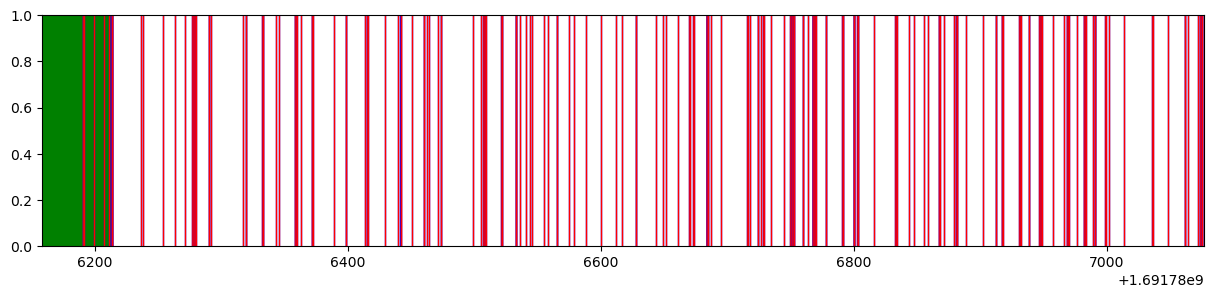

In [172]:
fig, ax = plt.subplots(1,1,figsize = (15,3))
for a_ind in range(artifact_time_list.shape[0]):
    ax.axvline(artifact_time_list[a_ind][0],color = 'b',linewidth = 1)
    ax.axvline(artifact_time_list[a_ind][1],color = 'r',linewidth = 1)
    #print(np.diff(artifact_time_list[a_ind]))

for a_ind in range(artifact_removed_time_list.shape[0]):
    ax.axvspan(artifact_removed_time_list[a_ind][0],artifact_removed_time_list[a_ind][1],color = 'g',linewidth = 1)

ax.set_xlim(trial_1_t,trial_last_t)

In [83]:
artifact_removed_time_list[-1][-1]

1691786212.2954159

In [75]:
test = interval_list_intersect(artifact_removed_time_list,np.array([trial_1_t,trial_last_t]))

In [82]:
test[-1][-1]

1691786212.2954159

In [48]:
artifact_removed_valid_times = (ArtifactRemovedIntervalList & {
    'artifact_removed_interval_list_name':
    'Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}
).fetch1("artifact_removed_valid_times")

In [50]:
artifact_removed_valid_times[-1][-1]

1691786212.2954159

In [69]:
artifact_time_list[-1][0]

1691787094.6425176

In [51]:
int(marks.time[-1])

1691786212

In [54]:
position_df.index[-10]

1691787077.2412632

In [57]:
trial_last_t

1691787077.2597272

In [20]:
positionIntervalList = (
        IntervalList &
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]})

marks_selection = ((UnitMarks & mark_parameters_keys) * positionIntervalList)
marks_selection = (pd.DataFrame(marks_selection)
                   .loc[:, marks_selection.primary_key]
                   .to_dict('records'))
UnitMarksIndicatorSelection.insert(marks_selection, skip_duplicates=True)

In [21]:
UnitMarksIndicatorSelection() & {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,interval_list_name descriptive name of this interval list,sampling_rate
0,Julio20230811_.nwb,2,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,3,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,6,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,7,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,8,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,11,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,12,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,15,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,20,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0
0,Julio20230811_.nwb,22,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0


In [22]:
UnitMarksIndicator.populate(marks_selection)

[20:07:06][INFO] Spyglass: Writing new NWB file Julio20230811_GQ1JYSFHFJ.nwb
20-Apr-25 20:07:06 Writing new NWB file Julio20230811_GQ1JYSFHFJ.nwb
[20:07:09][INFO] Spyglass: Writing new NWB file Julio20230811_ET4QYAPL8C.nwb
20-Apr-25 20:07:09 Writing new NWB file Julio20230811_ET4QYAPL8C.nwb
[20:07:12][INFO] Spyglass: Writing new NWB file Julio20230811_K2LVYK4E0Z.nwb
20-Apr-25 20:07:12 Writing new NWB file Julio20230811_K2LVYK4E0Z.nwb
[20:07:14][INFO] Spyglass: Writing new NWB file Julio20230811_B40H72ADKA.nwb
20-Apr-25 20:07:14 Writing new NWB file Julio20230811_B40H72ADKA.nwb
[20:07:17][INFO] Spyglass: Writing new NWB file Julio20230811_0DBT4AZOLS.nwb
20-Apr-25 20:07:17 Writing new NWB file Julio20230811_0DBT4AZOLS.nwb
[20:07:19][INFO] Spyglass: Writing new NWB file Julio20230811_JQ38MZTRT2.nwb
20-Apr-25 20:07:19 Writing new NWB file Julio20230811_JQ38MZTRT2.nwb
[20:07:22][INFO] Spyglass: Writing new NWB file Julio20230811_W3AHIS37PH.nwb
20-Apr-25 20:07:22 Writing new NWB file Julio20

In [23]:
marks = (UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name,
    'interval_list_name': position_interval[e],   
}).fetch_xarray()
marks.shape

(27232, 4, 25)

After you get the marks, it is important to visualize them to make sure they look right. We can use the `plot_all_marks` method of UnitMarksIndicator to quickly plot each mark feature against the other for each electrode.

Here it is important to look for things that look overly correlated (strong diagonal on the off-diagonal plots) and for extreme amplitudes.

In [24]:
UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name  
}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,interval_list_name descriptive name of this interval list,sampling_rate,analysis_file_name name of the file,marks_indicator_object_id
0,Julio20230811_.nwb,2,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_GQ1JYSFHFJ.nwb,ecfd4344-69c5-4419-8913-63a51b5b881a
0,Julio20230811_.nwb,3,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_ET4QYAPL8C.nwb,d815f0ce-5e5a-4c54-bd2f-7cdffa2a92c6
0,Julio20230811_.nwb,6,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_K2LVYK4E0Z.nwb,414532b9-35ee-426a-9034-a8cad32bf0bc
0,Julio20230811_.nwb,7,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_B40H72ADKA.nwb,c38787d0-6d15-45a0-a8a9-bac19c4b75bb
0,Julio20230811_.nwb,8,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_0DBT4AZOLS.nwb,8dffc59b-5784-4e78-acfe-670c167b8db8
0,Julio20230811_.nwb,11,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_11_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_JQ38MZTRT2.nwb,0f3028bc-03e3-4cb8-9b26-2686815861ab
0,Julio20230811_.nwb,12,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_W3AHIS37PH.nwb,5001d036-12c2-4968-8188-20e8a91c6ac8
0,Julio20230811_.nwb,15,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_GJ6NIQ3OKE.nwb,3a2cc2b3-466f-4ab9-91c6-d96c7f8a834e
0,Julio20230811_.nwb,20,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_JKNKADR8XS.nwb,38f67bd2-944c-4902-b5d2-202da30995f8
0,Julio20230811_.nwb,22,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,Julio20230811_.nwb_06_Seq2Session3_22_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 5 valid times,500.0,Julio20230811_TTPWP55LL2.nwb,5a5c382e-d611-4617-b1bf-9116eea2cd6e


## 2. Position

After the marks look good, you'll need to load/populate the 2D position data. This comes from the `IntervalPositionInfo` table. See the position tutorial for more information. Note that we will need to upsample the position data (which is done here via the `default_decoding` parameters) to match the sampling frequency that we intend to decode in (2 ms time bins or 500 Hz sampling rate)

Next we populate/load the linearized position tables. Again refer to the linear position tutorials for more information.

In [25]:
position_df = (IntervalPositionInfo &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
              ).fetch1_dataframe()

In [26]:
position_df

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.691786e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.691786e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.691786e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.691786e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.691786e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1.691787e+09,213.875,232.710227,1.458069,1.325212,-0.721271,1.508781
1.691787e+09,213.875,232.704545,1.458069,1.297402,-0.717262,1.482470
1.691787e+09,213.875,232.698864,1.458070,1.269694,-0.713004,1.456193


In [27]:
from spyglass.common.common_position import IntervalLinearizedPosition

linear_position_df = (IntervalLinearizedPosition() &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
).fetch1_dataframe()

linear_position_df

[20:40:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
20-Apr-25 20:40:21 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.691786e+09,NaN,0,NaN,NaN
1.691786e+09,NaN,0,NaN,NaN
1.691786e+09,NaN,0,NaN,NaN
1.691786e+09,NaN,0,NaN,NaN
1.691786e+09,NaN,0,NaN,NaN
...,...,...,...,...
1.691787e+09,1.538229,0,210.356749,232.465479
1.691787e+09,1.543897,0,210.357143,232.459825
1.691787e+09,1.549565,0,210.357536,232.454170


We should also quickly visualize the linear position in order to sanity check the values. Here we plot the 2D position projected to its corresponding 1D segment.

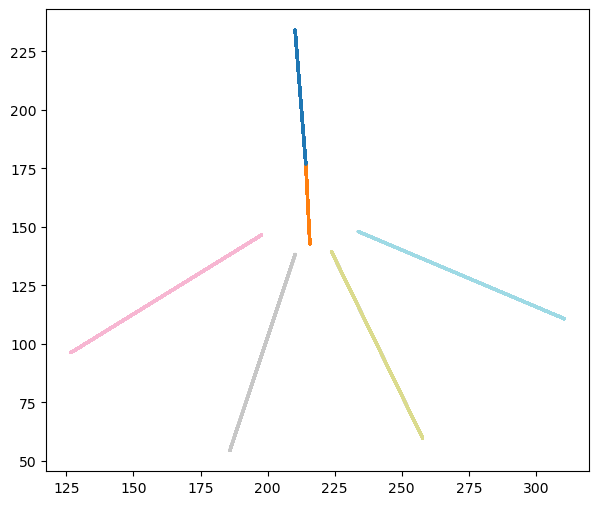

In [28]:
plt.figure(figsize=(7, 6))
plt.scatter(linear_position_df.projected_x_position, linear_position_df.projected_y_position,
            c=linear_position_df.track_segment_id, cmap='tab20', s=1)

We should also plot the linearized position itself to make sure it is okay.

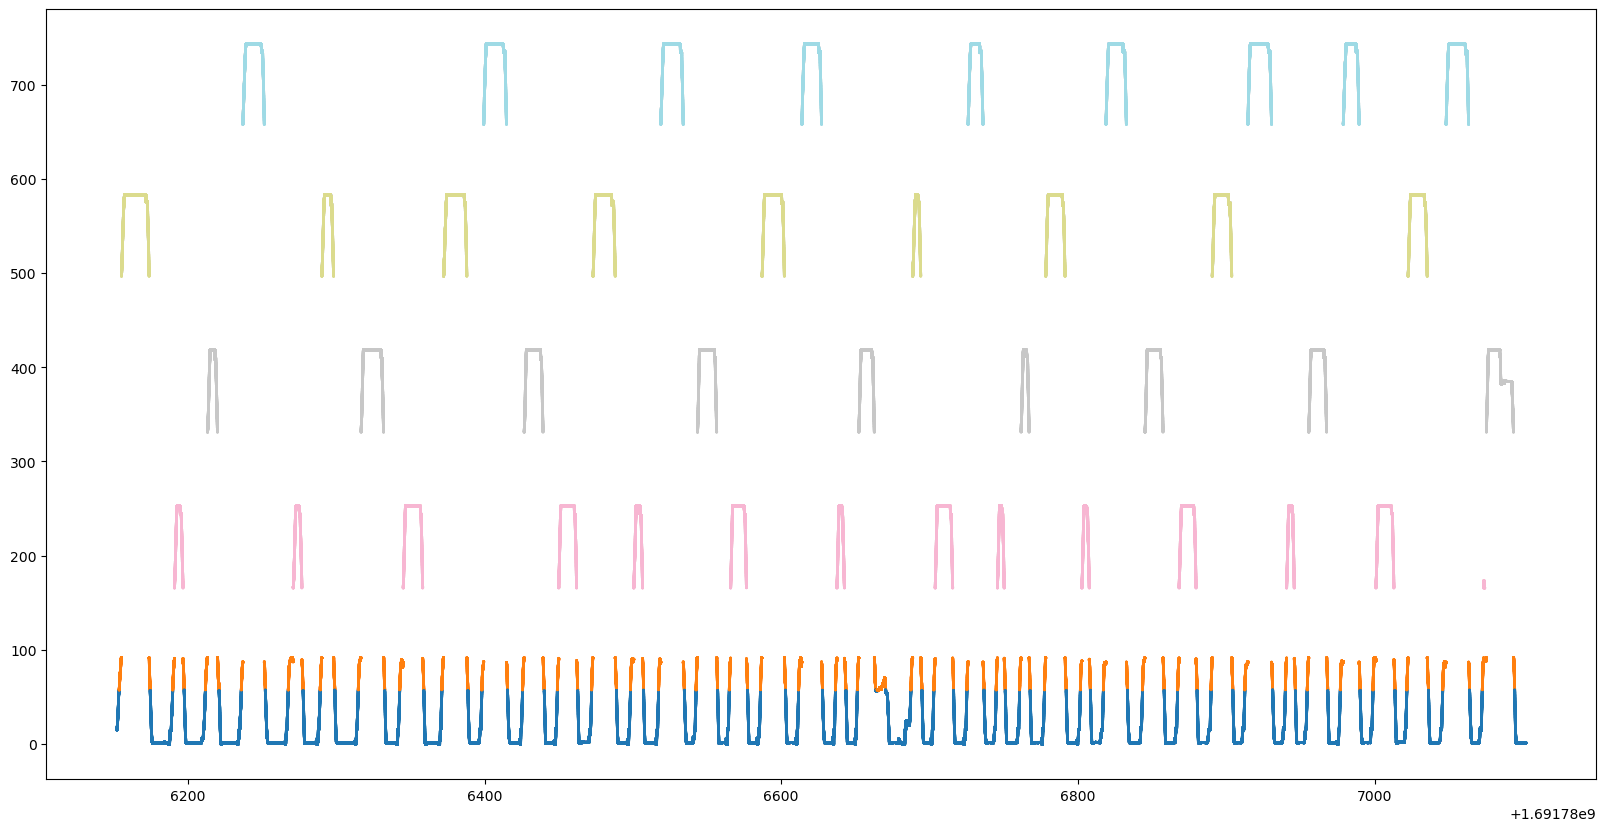

In [29]:
plt.figure(figsize=(20, 10))
plt.scatter(linear_position_df.index, linear_position_df.linear_position, s=1,
            c=linear_position_df.track_segment_id, cmap='tab20')

Okay now that we've looked at the data, we should quickly verify that all our data is the same size.

We also want to make sure we have valid ephys data and valid position data for decoding. Here we only have one valid time interval, but if we had more than one, we should decode on each interval separately.

In [30]:
intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])
marks_=[]
linear_position_df_=[]
position_df_ =[]
for i in range(len(intersect_interval)):
    valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])
    
    linear_position_df_.append(linear_position_df.loc[valid_time_slice])
    position_df_.append(position_df.loc[valid_time_slice])
    marks_.append(marks.sel(time=valid_time_slice))

marks=xr.concat(marks_,dim='time')
position_df = pd.concat(position_df_)
linear_position_df=pd.concat(linear_position_df_)
marks.shape, position_df.shape, linear_position_df.shape

((27228, 4, 25), (459605, 6), (459605, 4))

1691786212

1691787077.2592633

In [44]:
1000/60

16.666666666666668

In [33]:
animal = nwb_copy_file_name[:5]
marks_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_marks.nc')
marks.to_netcdf(marks_path)

position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
linear_position_df.to_csv(position1d_path)

position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
position_df.to_csv(position2d_path)

In [34]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e],
     'marks':marks_path,
     'position_1d':position1d_path,
     'position_2d':position2d_path}
DecodeIngredients().insert1(key,replace=True)

In [50]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
DecodeIngredients() & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"
molly20220419_.nwb,02_Seq2Session1,=BLOB=,=BLOB=,=BLOB=
molly20220419_.nwb,04_Seq2Session2,=BLOB=,=BLOB=,=BLOB=
molly20220419_.nwb,06_Seq2Session3,=BLOB=,=BLOB=,=BLOB=
molly20220419_.nwb,08_Seq2Session4,=BLOB=,=BLOB=,=BLOB=
molly20220419_.nwb,10_Seq2Session5,=BLOB=,=BLOB=,=BLOB=


# Run All sessions

In [10]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(nwb_copy_file_name)
print(session_interval)

Julio20230811_.nwb
['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '07_Seq2Session4', '09_Seq2Session5']


In [11]:
sleep_interval, sleep_position_interval = sleepSessionNames(nwb_copy_file_name)
print(nwb_copy_file_name)
print(sleep_interval)

Julio20230811_.nwb
['01_Seq2Sleep1', '03_Seq2Sleep2', '05_Seq2Sleep3', '08_Seq2Sleep4', '10_Seq2Sleep5']


In [ ]:
for e in session_interval:
    decodePrepMasterSession(nwb_copy_file_name,e,populate = True)

2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
8
inserting into IntervalList
done inserting into IntervalList
11
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
20
inserting into IntervalList
done inserting into IntervalList
22
inserting into IntervalList
done inserting into IntervalList
26
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
29
inserting into IntervalList
done inserting into IntervalList
30
inserting into IntervalList
done inserting into IntervalList
31
inserting into IntervalList
done inserting into IntervalList
36
inserting into IntervalList
done inserting

In [12]:
%debug

> /tmp/ipykernel_145225/3496828661.py(1)<module>()
----> 1 sleep_interval, sleep_position_interval = sleepSessionNames(nwb_copy_file_name)
      2 print(nwb_copy_file_name)
      3 print(sleep_interval)



ipdb>  exit


In [ ]:
ArtifactDetectionSelection & {}

In [14]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/common/common_interval.py(299)_intersection()
    297 def _intersection(interval1, interval2):
    298     """Takes the (set-theoretic) intersection of two intervals"""
--> 299     start = max(interval1[0], interval2[0])
    300     end = min(interval1[1], interval2[1])
    301     intersection = np.array([start, end]) if end > start else None



ipdb>  interval2


array([], dtype=float64)


ipdb>  interval1


array([1.65022621e+09, 1.65022823e+09])


ipdb>  up


> /home/shijiegu/Documents/spyglass/src/spyglass/common/common_interval.py(282)<listcomp>()
    280         for interval2 in interval_list2
    281         for interval1 in interval_list1
--> 282         if _intersection(interval2, interval1) is not None
    283     ]
    284 



ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/common/common_interval.py(278)interval_list_intersect()
    276 
    277     # then do pairwise comparison and collect intersections
--> 278     intersecting_intervals = [
    279         _intersection(interval2, interval1)
    280         for interval2 in interval_list2



ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/decodeHelpers.py(228)thresholder_sort()
    226         trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
    227 
--> 228         artifact_removed_time_list=interval_list_intersect(artifact_removed_time_list,np.array([trial_1_t,trial_last_t]))
    229     else:
    230         artifact_removed_time_list = artifact_removed_time_list.reshape((-1,2))



ipdb>  np.array([trial_1_t,trial_last_t]


*** SyntaxError: unexpected EOF while parsing


ipdb>  np.array([trial_1_t,trial_last_t])


array([1.65022621e+09, 1.65022823e+09])


ipdb>  artifact_removed_time_list


array([], dtype=float64)


ipdb>  exit


In [32]:
ArtifactDetectionSelection

spyglass.spikesorting.v0.spikesorting_artifact.ArtifactDetectionSelection

In [51]:
for e in sleep_interval:
    thresholder_sort(nwb_copy_file_name,e,True)

0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
10
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
done inserting into IntervalList
37
inserting into IntervalList
done inserting 

[14:43:52][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:43:52 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:43:56][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:43:56 Saving sorting results...
[14:43:58][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:43:58 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_10_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:44:01][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:44:01 Saving sorting results...
[14:44:04][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:44:04 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:44:08][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:44:08 Saving sorting results...
[14:44:10][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:44:10 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:44:15][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:44:15 Saving sorting results...
[14:44:20][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:44:20 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_17_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:44:24][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:44:24 Saving sorting results...
[14:44:30][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_18_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:44:30 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_18_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:44:35][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:44:35 Saving sorting results...
[14:44:37][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_24_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:44:37 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_24_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:44:41][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:44:41 Saving sorting results...
[14:44:44][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_25_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:44:44 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_25_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:44:47][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:44:47 Saving sorting results...
[14:44:49][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:44:49 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_27_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:44:53][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:44:53 Saving sorting results...
[14:44:56][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:44:56 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:44:59][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:44:59 Saving sorting results...
[14:45:01][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:45:01 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_34_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:45:05][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:45:05 Saving sorting results...
[14:45:08][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:45:08 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_37_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:45:11][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:45:11 Saving sorting results...
[14:45:14][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:45:14 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_39_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:45:18][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:45:18 Saving sorting results...
[14:45:20][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:45:20 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:45:24][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:45:24 Saving sorting results...
[14:45:29][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_40_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:45:29 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_40_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:45:32][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:45:32 Saving sorting results...
[14:45:38][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_41_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:45:38 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_41_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:45:42][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:45:42 Saving sorting results...
[14:45:48][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_46_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:45:48 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_46_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:45:53][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:45:53 Saving sorting results...
[14:45:56][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:45:56 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_50_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:46:00][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:00 Saving sorting results...
[14:46:02][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_52_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:02 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_52_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:46:06][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:06 Saving sorting results...
[14:46:08][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:08 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_53_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:46:12][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:12 Saving sorting results...
[14:46:14][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_60_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:14 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_60_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:46:18][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:18 Saving sorting results...
[14:46:21][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:21 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_61_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:46:24][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:24 Saving sorting results...
[14:46:26][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:26 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:46:30][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:30 Saving sorting results...
[14:46:32][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:32 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:46:36][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:36 Saving sorting results...
[14:46:38][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:38 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '01_Seq2Sleep1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_01_Seq2Sleep1_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2021 [00:00<?, ?it/s]

[14:46:42][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:42 Saving sorting results...


0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
10
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
done inserting into IntervalList
37
inserting into IntervalList
done inserting 

[14:46:44][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:44 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:46:48][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:48 Saving sorting results...
[14:46:51][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:51 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_10_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:46:54][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:46:54 Saving sorting results...
[14:46:59][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:46:59 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:02][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:02 Saving sorting results...
[14:47:07][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:07 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:10][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:10 Saving sorting results...
[14:47:13][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:13 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_17_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:17][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:17 Saving sorting results...
[14:47:19][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_18_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:19 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_18_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:22][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:22 Saving sorting results...
[14:47:24][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_24_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:24 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_24_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:27][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:27 Saving sorting results...
[14:47:29][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_25_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:29 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_25_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:32][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:32 Saving sorting results...
[14:47:34][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:34 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_27_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:38][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:38 Saving sorting results...
[14:47:40][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:40 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:43][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:43 Saving sorting results...
[14:47:45][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:45 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_34_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:48][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:48 Saving sorting results...
[14:47:50][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:50 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_37_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:53][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:53 Saving sorting results...
[14:47:55][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:47:55 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_39_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:47:58][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:47:58 Saving sorting results...
[14:48:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:00 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:48:04][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:48:04 Saving sorting results...
[14:48:06][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_40_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:06 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_40_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:48:09][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:48:09 Saving sorting results...
[14:48:14][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_41_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:14 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_41_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:48:17][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:48:17 Saving sorting results...
[14:48:21][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_46_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:21 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_46_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:48:25][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:48:25 Saving sorting results...
[14:48:31][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:31 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_50_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:48:34][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:48:34 Saving sorting results...
[14:48:37][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_52_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:37 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_52_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:48:40][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:48:40 Saving sorting results...
[14:48:42][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:42 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_53_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:48:45][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:48:45 Saving sorting results...
[14:48:47][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_60_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:47 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_60_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:48:51][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:48:51 Saving sorting results...
[14:48:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:53 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_61_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:48:56][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:48:56 Saving sorting results...
[14:48:58][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:48:58 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:49:01][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:49:01 Saving sorting results...
[14:49:03][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:49:03 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:49:07][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:49:07 Saving sorting results...
[14:49:09][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:49:09 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '03_Seq2Sleep2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_03_Seq2Sleep2_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1723 [00:00<?, ?it/s]

[14:49:12][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:49:12 Saving sorting results...


0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
10
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
done inserting into IntervalList
37
inserting into IntervalList
done inserting 

[14:49:15][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:49:15 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:49:18][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:49:18 Saving sorting results...
[14:49:20][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:49:20 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_10_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:49:24][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:49:24 Saving sorting results...
[14:49:30][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:49:30 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:49:34][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:49:34 Saving sorting results...
[14:49:39][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:49:39 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:49:42][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:49:42 Saving sorting results...
[14:49:48][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:49:48 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_17_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:49:51][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:49:51 Saving sorting results...
[14:49:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_18_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:49:53 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_18_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:49:58][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:49:58 Saving sorting results...
[14:50:01][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_24_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:50:01 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_24_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:50:05][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:50:05 Saving sorting results...
[14:50:07][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_25_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:50:07 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_25_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:50:11][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:50:11 Saving sorting results...
[14:50:14][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:50:14 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_27_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:50:17][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:50:17 Saving sorting results...
[14:50:19][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:50:19 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:50:23][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:50:23 Saving sorting results...
[14:50:26][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:50:26 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_34_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:50:30][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:50:30 Saving sorting results...
[14:50:33][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:50:33 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_37_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:50:37][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:50:37 Saving sorting results...
[14:50:40][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:50:40 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_39_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:50:44][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:50:44 Saving sorting results...
[14:50:47][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:50:47 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:50:51][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:50:51 Saving sorting results...
[14:50:55][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_40_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:50:55 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_40_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:51:00][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:51:00 Saving sorting results...
[14:51:04][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_41_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:51:04 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_41_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:51:08][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:51:08 Saving sorting results...
[14:51:13][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_46_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:51:13 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_46_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:51:17][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:51:17 Saving sorting results...
[14:51:23][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:51:23 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_50_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:51:27][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:51:27 Saving sorting results...
[14:51:30][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_52_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:51:30 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_52_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:51:35][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:51:35 Saving sorting results...
[14:51:37][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:51:37 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_53_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:51:41][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:51:41 Saving sorting results...
[14:51:44][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_60_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:51:44 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_60_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:51:47][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:51:47 Saving sorting results...
[14:51:50][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:51:50 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_61_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:51:54][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:51:54 Saving sorting results...
[14:51:58][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:51:58 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:52:02][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:52:02 Saving sorting results...
[14:52:04][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:52:04 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:52:08][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:52:08 Saving sorting results...
[14:52:10][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:52:10 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_05_Seq2Sleep3_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1960 [00:00<?, ?it/s]

[14:52:13][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:52:13 Saving sorting results...


0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
10
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
done inserting into IntervalList
37
inserting into IntervalList
done inserting 

[14:52:22][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:52:22 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:52:28][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:52:28 Saving sorting results...
[14:52:36][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:52:36 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_10_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:52:42][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:52:42 Saving sorting results...
[14:52:48][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:52:48 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:53:28][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:53:28 Saving sorting results...
[14:53:34][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:53:34 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:54:09][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:54:09 Saving sorting results...
[14:54:16][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:54:16 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_17_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:54:25][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:54:25 Saving sorting results...
[14:54:31][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_18_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:54:31 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_18_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:55:00][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:55:00 Saving sorting results...
[14:55:02][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_24_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:55:02 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_24_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:55:06][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:55:06 Saving sorting results...
[14:55:08][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_25_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:55:08 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_25_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:55:12][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:55:12 Saving sorting results...
[14:55:16][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:55:16 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_27_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:55:26][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:55:26 Saving sorting results...
[14:55:30][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:55:30 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:55:37][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:55:37 Saving sorting results...
[14:55:42][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:55:42 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_34_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:55:49][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:55:49 Saving sorting results...
[14:55:54][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:55:54 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_37_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:56:01][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:56:01 Saving sorting results...
[14:56:05][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:56:05 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_39_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:56:18][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:56:18 Saving sorting results...
[14:56:22][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:56:22 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:56:31][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:56:31 Saving sorting results...
[14:57:02][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:57:02 Saving sorting results...
[14:57:04][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_52_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:57:04 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_inte

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:57:08][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:57:08 Saving sorting results...
[14:57:11][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:57:11 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_53_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:57:15][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:57:15 Saving sorting results...
[14:57:18][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_60_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:57:18 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_60_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:57:22][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:57:22 Saving sorting results...
[14:57:25][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:57:25 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_61_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:57:29][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:57:29 Saving sorting results...
[14:57:31][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:57:31 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:57:35][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:57:35 Saving sorting results...
[14:57:37][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:57:37 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:57:40][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:57:40 Saving sorting results...
[14:57:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:57:43 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '07_Seq2Sleep4', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_07_Seq2Sleep4_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1937 [00:00<?, ?it/s]

[14:57:46][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:57:46 Saving sorting results...


0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
10
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
done inserting into IntervalList
37
inserting into IntervalList
done inserting 

[14:57:50][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:57:50 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:57:54][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:57:54 Saving sorting results...
[14:57:58][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:57:58 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_10_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:58:02][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:58:02 Saving sorting results...
[14:58:06][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:58:06 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:58:10][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:58:10 Saving sorting results...
[14:58:13][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:58:13 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:58:18][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:58:18 Saving sorting results...
[14:58:21][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:58:21 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_17_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:58:26][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:58:26 Saving sorting results...
[14:58:29][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_18_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:58:29 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_18_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:58:33][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:58:33 Saving sorting results...
[14:58:37][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_24_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:58:37 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_24_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:58:42][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:58:42 Saving sorting results...
[14:58:45][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_25_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:58:45 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_25_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:58:50][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:58:50 Saving sorting results...
[14:58:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:58:53 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_27_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:58:58][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:58:58 Saving sorting results...
[14:59:03][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:59:03 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:59:07][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:59:07 Saving sorting results...
[14:59:11][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:59:11 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_34_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:59:15][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:59:15 Saving sorting results...
[14:59:19][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:59:19 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_37_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:59:23][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:59:23 Saving sorting results...
[14:59:27][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:59:27 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_39_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:59:32][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:59:32 Saving sorting results...
[14:59:36][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:59:36 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:59:40][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:59:40 Saving sorting results...
[14:59:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_40_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:59:43 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_40_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:59:48][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:59:48 Saving sorting results...
[14:59:52][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_41_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 14:59:52 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_41_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[14:59:57][INFO] Spyglass: Saving sorting results...
28-Mar-25 14:59:57 Saving sorting results...
[15:00:01][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_46_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:00:01 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_46_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[15:00:05][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:00:05 Saving sorting results...
[15:00:08][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:00:08 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_50_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[15:00:14][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:00:14 Saving sorting results...
[15:00:17][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_52_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:00:17 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_52_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[15:00:22][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:00:22 Saving sorting results...
[15:00:25][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:00:25 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_53_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[15:00:29][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:00:29 Saving sorting results...
[15:00:33][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_60_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:00:33 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_60_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[15:00:38][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:00:38 Saving sorting results...
[15:00:41][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:00:41 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_61_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[15:00:45][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:00:45 Saving sorting results...
[15:00:48][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:00:48 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[15:00:53][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:00:53 Saving sorting results...
[15:00:57][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:00:57 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[15:01:01][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:01:01 Saving sorting results...
[15:01:05][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:01:05 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '09_Seq2Sleep5', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_09_Seq2Sleep5_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/2608 [00:00<?, ?it/s]

[15:01:09][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:01:09 Saving sorting results...


0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
10
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
done inserting into IntervalList
37
inserting into IntervalList
done inserting 

[15:01:12][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:01:12 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 0, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:01:16][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:01:16 Saving sorting results...
[15:01:19][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:01:19 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 10, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_10_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:01:23][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:01:23 Saving sorting results...
[15:01:25][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:01:25 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 12, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_12_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:01:29][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:01:29 Saving sorting results...
[15:01:32][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:01:32 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 15, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_15_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:01:36][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:01:36 Saving sorting results...
[15:01:38][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:01:38 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 17, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_17_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:01:42][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:01:42 Saving sorting results...
[15:01:45][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_18_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:01:45 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 18, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_18_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:01:48][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:01:48 Saving sorting results...
[15:01:51][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_24_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:01:51 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 24, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_24_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:01:54][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:01:54 Saving sorting results...
[15:01:57][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_25_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:01:57 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 25, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_25_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:02:01][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:02:01 Saving sorting results...
[15:02:03][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_27_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:02:03 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 27, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_27_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:02:07][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:02:07 Saving sorting results...
[15:02:09][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:02:09 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 2, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:02:12][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:02:12 Saving sorting results...
[15:02:15][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:02:15 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 34, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_34_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:02:18][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:02:18 Saving sorting results...
[15:02:20][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:02:20 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 37, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_37_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:02:29][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:02:29 Saving sorting results...
[15:02:32][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:02:32 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 39, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_39_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:02:35][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:02:35 Saving sorting results...
[15:02:38][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:02:38 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 3, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_3_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:02:42][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:02:42 Saving sorting results...
[15:02:45][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_40_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:02:45 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 40, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_40_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:02:50][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:02:50 Saving sorting results...
[15:02:52][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_41_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:02:52 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 41, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_41_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:02:57][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:02:57 Saving sorting results...
[15:03:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_46_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:03:00 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 46, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_46_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:03:04][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:03:04 Saving sorting results...
[15:03:06][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:03:06 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 50, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_50_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:03:11][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:03:11 Saving sorting results...
[15:03:13][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_52_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:03:13 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 52, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_52_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:03:18][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:03:18 Saving sorting results...
[15:03:20][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:03:20 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 53, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_53_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:03:25][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:03:25 Saving sorting results...
[15:03:28][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_60_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:03:28 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 60, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_60_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:03:33][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:03:33 Saving sorting results...
[15:03:35][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:03:35 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 61, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_61_franklab_tetrode_hippocampus_ampl_1500_prop_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:03:39][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:03:39 Saving sorting results...
[15:03:41][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:03:41 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 6, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_6_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:03:45][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:03:45 Saving sorting results...
[15:03:47][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:03:47 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 7, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:03:51][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:03:51 Saving sorting results...
[15:03:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
28-Mar-25 15:03:53 Running spike sorting on {'nwb_file_name': 'molly20220419_.nwb', 'sort_group_id': 9, 'sort_interval_name': '11_Seq2Sleep6', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220419_.nwb_11_Seq2Sleep6_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_

detect peaks using locally_exclusive:   0%|          | 0/1931 [00:00<?, ?it/s]

[15:03:57][INFO] Spyglass: Saving sorting results...
28-Mar-25 15:03:57 Saving sorting results...


In [23]:
%debug

> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/datajoint/connection.py(296)_execute_query()
    294                 cursor.execute(query, args)
    295         except client.err.Error as err:
--> 296             raise translate_query_error(err, query)
    297 
    298     def query(



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/datajoint/connection.py(340)query()
    338         cursor = self._conn.cursor(cursor=cursor_class)
    339         try:
--> 340             self._execute_query(cursor, query, args, suppress_warnings)
    341         except errors.LostConnectionError:
    342             if not reconnect:



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/datajoint/table.py(440)insert()
    438                     ),
    439                 )
--> 440                 self.connection.query(
    441                     query,
    442                     args=list(



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/datajoint/table.py(337)insert1()
    335             as one row.
    336         """
--> 337         self.insert((row,), **kwargs)
    338 
    339     def insert(



ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/decodeHelpers.py(249)thresholder_sort()
    247 
    248         if populate:
--> 249             ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)
    250 
    251         artifact_key['artifact_times']=artifact_time_list



ipdb>  artifact_key


{'nwb_file_name': 'eliot20221021_.nwb', 'sort_interval_name': '01_Seq2Sleep1', 'sort_group_id': 0, 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'artifact_params_name': 'ampl_1500_prop_075_1ms'}


ipdb>  exit


In [15]:
SpikeSortingRecording & {'nwb_file_name': 'molly20220418_.nwb', 'sort_interval_name': '01_Seq2Sleep1'}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list


In [13]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name}
DecodeIngredients() & key

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"


In [12]:
(SpikeSortingSelection & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,import_path optional path to previous curated sorting output
molly20220419_.nwb,0,01_Seq2Sleep1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220419_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220419_.nwb,0,03_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220419_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220419_.nwb,0,05_Seq2Sleep3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220419_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220419_.nwb,0,07_Seq2Sleep4,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220419_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220419_.nwb,0,09_Seq2Sleep5,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220419_.nwb,0,10_Seq2Session5,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,


In [13]:
(SpikeSorting & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
molly20220419_.nwb,0,01_Seq2Sleep1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus_42bc8de3_spikesorting,1743198236
molly20220419_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_7493c9f0_spikesorting,1743178710
molly20220419_.nwb,0,03_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus_0dd35597_spikesorting,1743198408
molly20220419_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_c677155e_spikesorting,1743179953
molly20220419_.nwb,0,05_Seq2Sleep3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus_66f52952_spikesorting,1743198558
molly20220419_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_c6421bd9_spikesorting,1743181192
molly20220419_.nwb,0,07_Seq2Sleep4,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus_444edfda_spikesorting,1743198748
molly20220419_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_e7377b69_spikesorting,1743182505
molly20220419_.nwb,0,09_Seq2Sleep5,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus_5414b4e0_spikesorting,1743199074
molly20220419_.nwb,0,10_Seq2Session5,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220419_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220419_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus_b26a62f3_spikesorting,1743183851


# END HERE

In [2]:
## try loading
nwb_copy_file_name = 'lewis20240121_.nwb'

In [44]:
e=0

In [45]:
entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e]}
marks = xr.open_dataset(entry.fetch1('marks'))
position_1d = pd.read_csv(entry.fetch1('position_1d'))
position_2d = pd.read_csv(entry.fetch1('position_2d'))

In [46]:
marks

<xarray.Dataset>
Dimensions:                        (time: 958279, marks: 4, electrodes: 15)
Coordinates:
  * time                           (time) float64 1.667e+09 ... 1.667e+09
  * electrodes                     (electrodes) int32 0 2 4 5 13 ... 28 29 30 31
  * marks                          (marks) object 'amplitude_0000' ... 'ampli...
Data variables:
    __xarray_dataarray_variable__  (time, marks, electrodes) float32 ...

In [47]:
for e in range(len(session_interval)):
    """
    Position: UnitMarksIndicator
    """
    linear_position_df = (IntervalLinearizedPosition() &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
        ).fetch1_dataframe()
    position_df = (IntervalPositionInfo &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
                    ).fetch1_dataframe()

    # Remove Data before 1st trial and after last trial
    StateScript = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,
                        'epoch_name':session_interval[e]}).fetch1('choice_reward'))

    trial_1_t = StateScript.loc[1].timestamp_O
    trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
    linear_position_df = removeDataBeforeTrial1(linear_position_df,trial_1_t,trial_last_t)
    position_df = removeDataBeforeTrial1(position_df,trial_1_t,trial_last_t)

    """
    Intervals
    """
    intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])

    linear_position_df_=[]
    position_df_ =[]
    for i in range(len(intersect_interval)):
        valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])

        linear_position_df_.append(linear_position_df.loc[valid_time_slice])
        position_df_.append(position_df.loc[valid_time_slice])


    linear_position_df=pd.concat(linear_position_df_)
    position_df=pd.concat(position_df_)
    print('final shape of marks and linear position df is:')

    print(linear_position_df.shape)

    """save result"""
    animal = nwb_copy_file_name[:5]


    position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
    linear_position_df.to_csv(position1d_path)

    position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
    position_df.to_csv(position2d_path)

[09:47:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:09 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(958279, 4)


[09:47:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:22 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(885994, 4)


[09:47:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:34 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(843218, 4)


[09:47:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:46 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(783223, 4)
